분류 성능비교
==

다루는 내용
--
- 분류 알고리즘 비교
- 교차검증
- 정적 성능평가 Confusion matrix  
- 동적 성능평가 ROC

데이터
--
- 포도주 품질 분류 https://goo.gl/Gyc8K7

출처
--
https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine/notebook



모듈 불러오기
--

In [86]:
import os
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier <- pip install xgboost
from sklearn.svm import SVC
from sklearn.svm import SVR # Support Vector Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from pathlib import Path
%matplotlib inline

데이터 읽기 (포도주 품질 평가)
--

In [87]:
if not Path("/content/MachingLearningHomeWork/homework/7week/").exists():
  !git clone --depth 1 https://github.com/jsuk10/MachingLearningHomeWork.git
os.listdir("/content/MachingLearningHomeWork/homework/7week/")
datapwd = "/content/MachingLearningHomeWork/homework/7week/"
wine = pd.read_csv(datapwd+'data/winequality-red.csv')
# 데이터 사본 https://goo.gl/m3eCrf

In [88]:
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [89]:
wine.shape

(1599, 12)

- fixed acidity - 결합 산도 
- volatile acidity - 휘발성 산도 
- citric acid - 시트르산 
- residual sugar - 잔류 설탕 
- chlorides	 - 염화물 
- free sulfur dioxide - 자유 이산화황 
- total sulfur dioxide - 총 이산화황 
- density - 밀도 
- pH - pH 
- sulphates - 황산염 
- alcohol - 알코올 
- quality - 품질 (0 ~ 10 점)

In [90]:
wine.info() # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [91]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [92]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## 여러 특성 한번에 보기 (박스 플롯)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Text major ticklabel objects>)

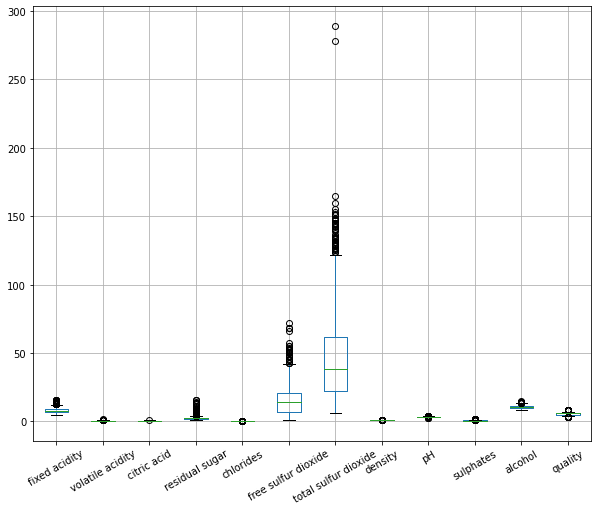

In [93]:
#맨처음에 박스플롯을 그린다 거의 한눈에 다보여주기 때문에
wine.boxplot(figsize = (10,8))
plt.xticks(rotation=30)

줄여서 보기
--

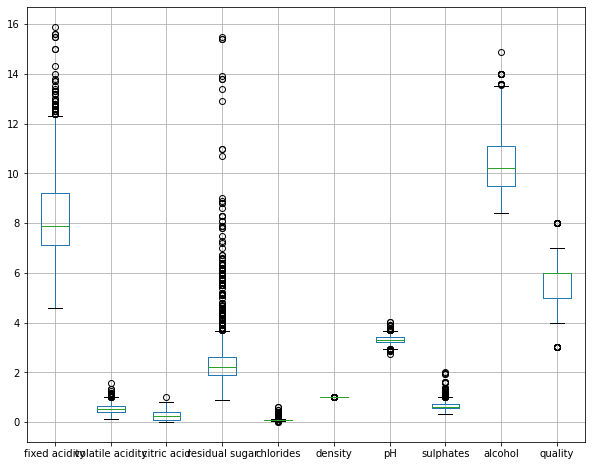

In [94]:
#위에서 크게나온 그림 빼고 다시그림 다른것들을 자세히 보기위해서
wine.drop(['free sulfur dioxide', 'total sulfur dioxide'], axis=1).boxplot(figsize = (10,8))

In [95]:
wine[['alcohol', 'quality']].head(10)

,alcohol,quality
0,9.4,5
1,9.8,5
2,9.8,5
3,9.8,6
4,9.4,5
5,9.4,5
6,9.4,5
7,10.0,7
8,9.5,7
9,10.5,5


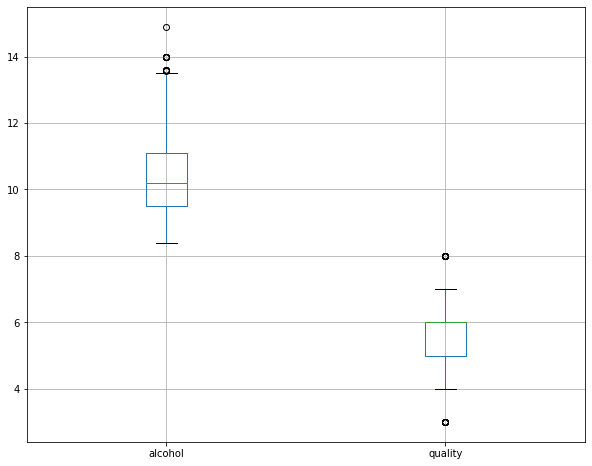

In [96]:
wine[['alcohol', 'quality']].boxplot(figsize = (10,8))

히스토그램
--

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb460a4c50>,
      dtype=object)

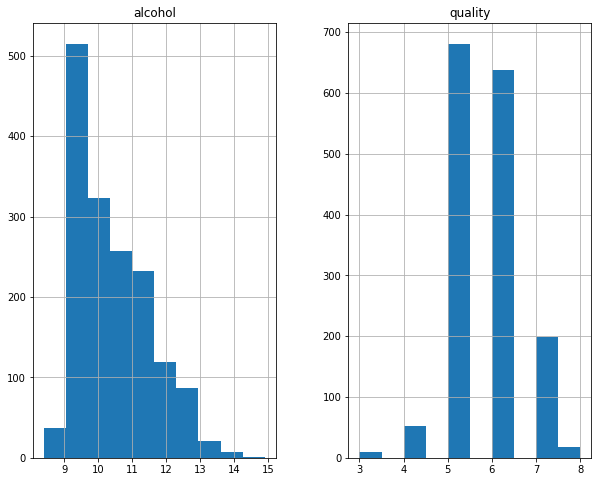

In [97]:
wine[['alcohol', 'quality']].hist(figsize = (10,8))

품질관련 데이터 파악
--

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


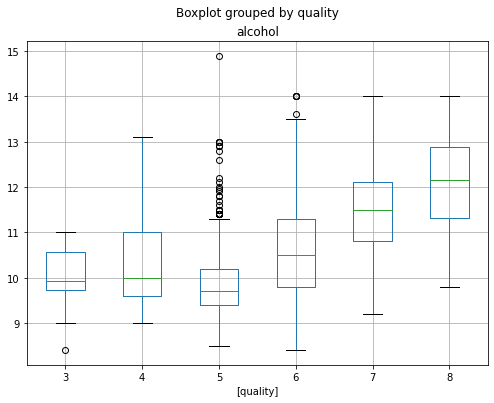

In [98]:
#퀄리티가 3인것만 모아서 그리고 4만모아서 그리고...
wine[['alcohol', 'quality']].boxplot(by='quality',figsize = (8,6)) # by값 - 기준
#quality가 좋은건 평균적으로 알코올 성분이 좋다.
#포도주도 알코올이 있는것들을 좋아함

In [99]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

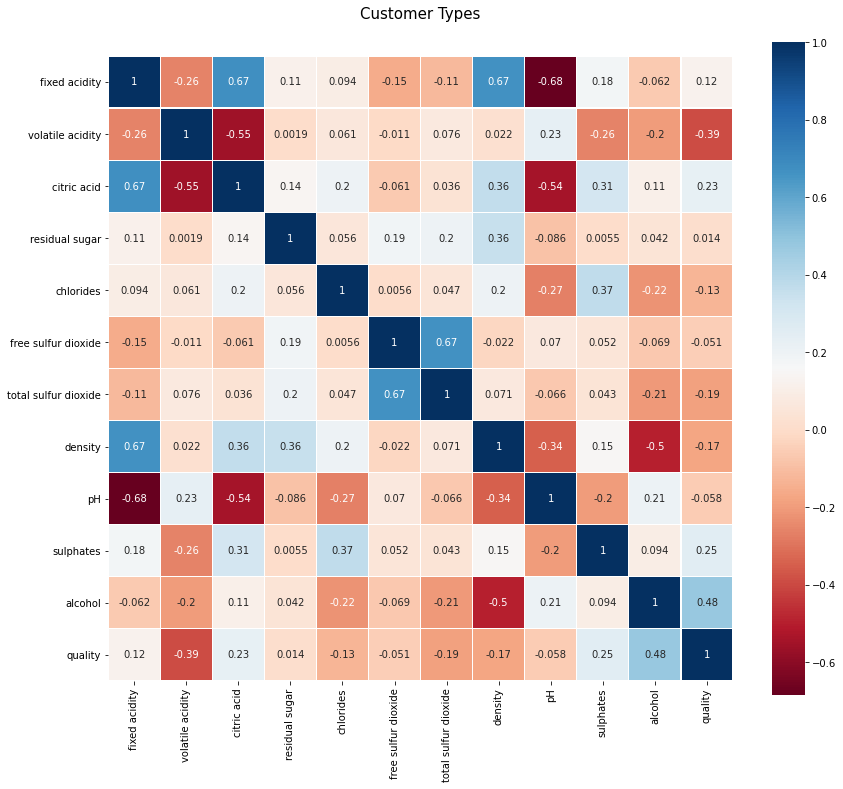

In [100]:
import seaborn as sns
heatmap_data = wine[wine.columns]
plt.figure(figsize=(14, 12))
colormap = plt.cm.RdBu
plt.title('Customer Types', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 10})

del heatmap_data

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb45ea5d90>,
      dtype=object)

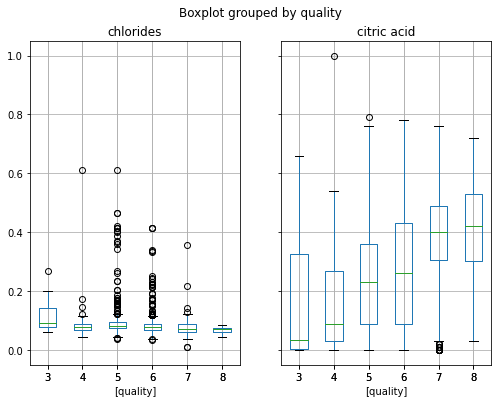

In [101]:
#chlorides : 염화물 , citric acid : 시트르산
wine1 = wine[[ 'chlorides', 'citric acid', 'quality']]
wine1.boxplot(by='quality',figsize = (8,6))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb45df8bd0>,
      dtype=object)

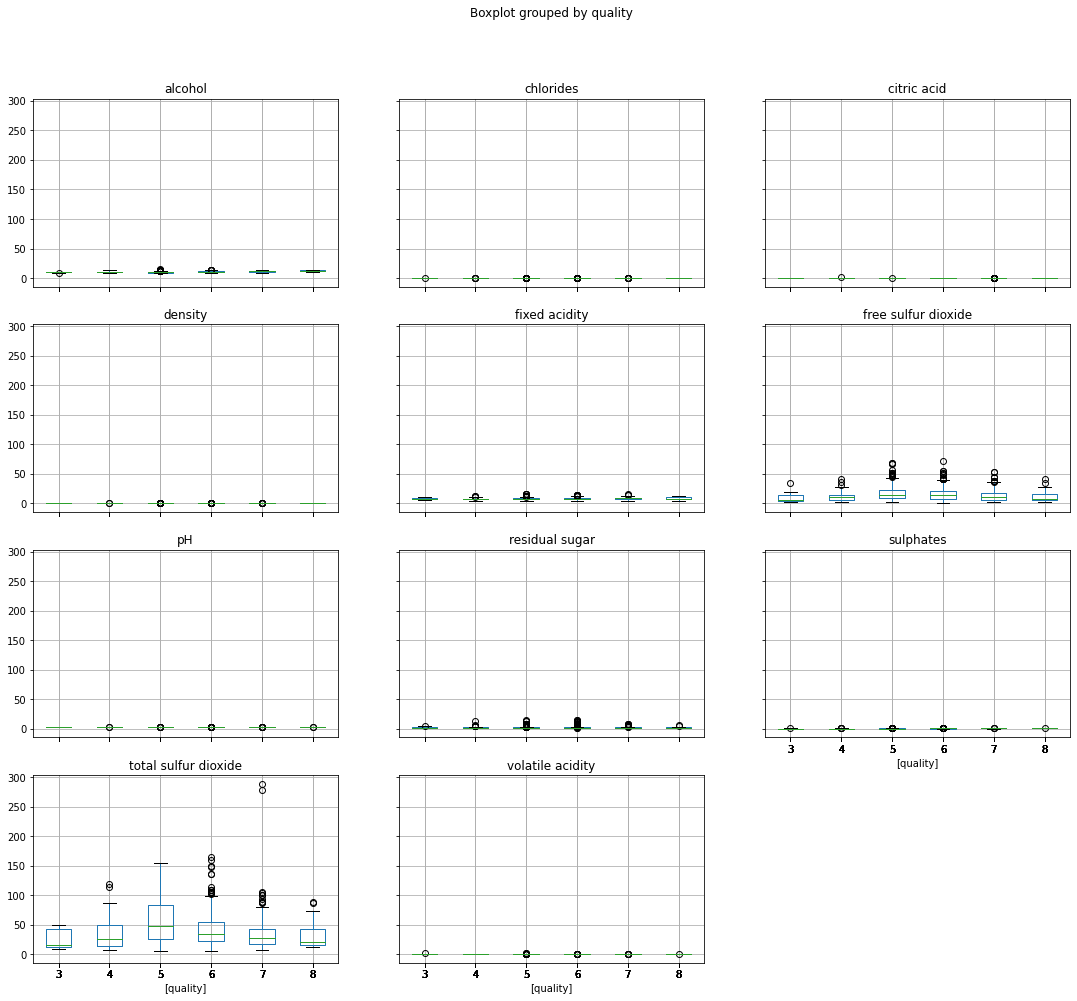

In [102]:
wine.boxplot(by='quality',figsize = (18,16))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb44a2e2d0>,
      dtype=object)

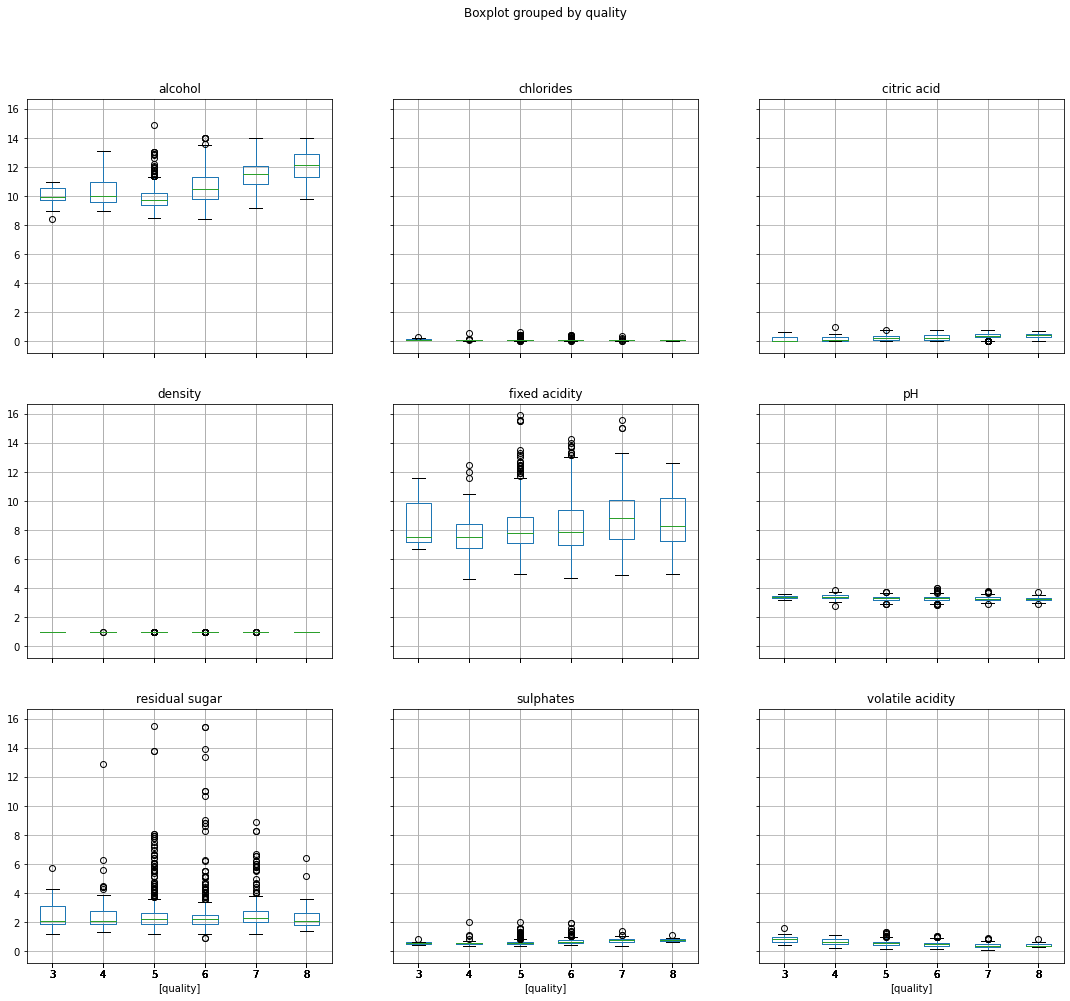

In [103]:
wine.drop(['free sulfur dioxide', 'total sulfur dioxide'], axis=1).boxplot(by='quality',figsize = (18,16))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb43f150d0>,
      dtype=object)

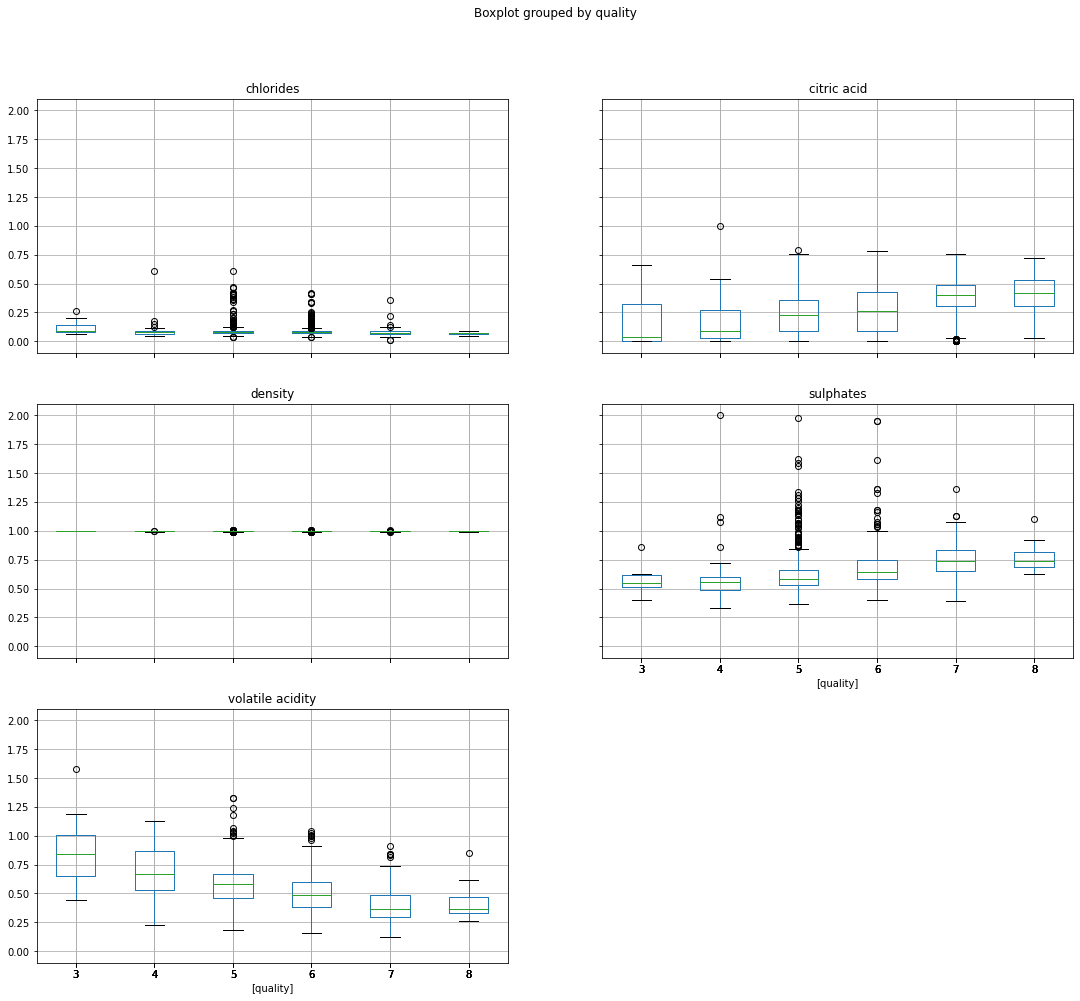

In [104]:
wine.drop(['free sulfur dioxide', 'total sulfur dioxide','alcohol','fixed acidity','residual sugar','pH'], axis=1).boxplot(by='quality',figsize = (18,16))

## 데이터 전처리 (레이블 만들기)

In [105]:
wine['quality'].unique()

array([5, 6, 7, 4, 8, 3])

In [106]:
wine.quality.unique() 

array([5, 6, 7, 4, 8, 3])

In [107]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [108]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
bins = (2.9, 6.5, 8.1)#bins 구간을 나눌때 쓴다.(마지막에 8을썼더니 컴퓨터나 8을 뺴버렸다. 그래서 8을 포함시키기 위해 안전하게 8.1을 사용)
# 현재 7.8만 맛있다가 되어있다.
#8만 잡게하면 성능이 좋아진다.
group_names = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = bins, labels = group_names) #cut 함수 2.9 초과 6.5 이하, 6.5 초과 8.1 이하로 범위를 나눠줌

In [109]:
wine.head(50)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,qual
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0
6,7.9,0.600,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,0
7,7.3,0.650,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,1
8,7.8,0.580,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,1
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,0


In [110]:
wine['qual'].value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [111]:
# 예측변수와 레이블을 나눈다
# X 데이터에서는 'quality'와 'qual' 컬럼 제거
# y는 레이블만 담는다

X_new = wine.drop(['quality', 'qual'], axis = 1)
y_ = wine['quality'] # regression 용
y = wine['qual'] 

In [112]:
X_new.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [113]:
y.value_counts()

0    1382
1     217
Name: qual, dtype: int64

표준 스케일링
--

전체 자료의 분포를 평균 0, 분산 1이 되도록 만든다.  
X에는 수치 데이터만 들어야 한다.  
테스트 데이터도 같이 스케일링하는 것을 잊지 않는다

In [114]:
sc = StandardScaler()
X = sc.fit_transform(X_new)
#fit을 하고 transform을 한번에 한것, 코드를 줄여주기 위해서
#fit은 데이터를 읽고 평균과 시그마를 구한다. (하나의 모델을 만듬, 여기에 들어가는 파라미터가 평균과 시그마) -> 스케일링 하기위한 상수구하기
#transform은 실제 값들을 넣어서 나오는 값들

#원래는 데이터를 자체적으로 나눠서 cross valredation을 해야한다. 하지만 지금은 통으로했다.

In [115]:
# 데이터 프레임에 스케일링 연산을 하면 ndarray로 바뀐다
X[:5]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711],
       [ 1.65485608, -1.38444349,  1.4841536 , -0.45321841, -0.26496041,
         0.10759209,  0.41150046,  0.6642772 , -0.97910442, -0.46118037,
        -0.58477711],
       [-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

In [116]:
X.sum()

-4.860112312599085e-11

In [117]:
# 데이터를 랜덤하게 섞은 후 80%를 훈련데이터로 사용
# random_state 같은 값으로 지정하면 랜덤하게 섞이는 순서가 같다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7) # 분류용
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y_, test_size = 0.2, random_state = 7) # 회귀용

#직접 실습을 해보는데 지금은 80%이지만 다르게 할 수도 있다.
#위에 모델을 바꿔서 6.5가 맛있다가 아니라 8만 맛있다 등 바꿔본다.

In [118]:
X_train.shape, y_train.shape

((1279, 11), (1279,))

In [119]:
X_test.shape, y_test.shape

((320, 11), (320,))

# 1. 분류

## KNN(K-최근접 이웃)

In [120]:
clf = KNeighborsClassifier(n_neighbors=3)
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.8875

결정 트리 (Decesion Tree)
--

In [121]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.8375

## 랜덤 포래스트 (Random Forest Classifier)

In [140]:
depths = [3,5,7]

In [150]:
for a in depths:
  rfc = RandomForestClassifier(max_depth=a, n_estimators=300) 
  rfc.fit(X_train, y_train)
  print("depth {} : {}".format(a,rfc.score(X_test,y_test)))

depth 3 : 0.89375
depth 5 : 0.896875
depth 7 : 0.9


In [151]:
for a in depths:
  rfc = RandomForestClassifier(max_depth=a, n_estimators=300) 
  rfc.fit(X_train, y_train)
  print("depth {} : {}".format(a,rfc.score(X_test,y_test)))

depth 3 : 0.890625
depth 5 : 0.884375
depth 7 : 0.89375


## 그라디언트 부스팅 (Gradient Boosting Classifier)

In [156]:
for a in depths:
  GBC = GradientBoostingClassifier(max_depth=a, n_estimators=100, learning_rate=0.1, random_state=42)
  GBC.fit(X_train, y_train)
  print("depth {} : {}".format(a,GBC.score(X_test,y_test)))

depth 3 : 0.896875
depth 5 : 0.9
depth 7 : 0.89375


In [157]:
for a in depths:
  GBC = GradientBoostingClassifier(max_depth=a, n_estimators=100, learning_rate=0.1, random_state=42)
  GBC.fit(X_train, y_train)
  print("depth {} : {}".format(a,GBC.score(X_test,y_test)))

depth 3 : 0.896875
depth 5 : 0.9
depth 7 : 0.89375


##  정적 평가, 혼돈 매트릭스 (confusion_matrix)

In [124]:
pred_rfc = rfc.predict(X_test)
confusion_matrix(y_test, pred_rfc)
# RandomForest에 대한 confusion_matrix

array([[267,  12],
       [ 22,  19]])

아래는 모델이 올바르게 예측했는지를 평가하기 위한 값들이다

In [125]:
# 여러 성능 지표를 출력한다
print(classification_report(y_test, pred_rfc))
#밑에 숫자는 0을 기준으로 0.94 맞춤 
#pos 긍정이 아닌 내가 찾고자 하는 답을 pos라고 봄(암환자)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       279
           1       0.61      0.46      0.53        41

    accuracy                           0.89       320
   macro avg       0.77      0.71      0.73       320
weighted avg       0.88      0.89      0.89       320



- Precision  = 모델이 옳다고 한 것이 실제로 옳은 비율     TP / ( TP + FP ) 
- Recall =  실제 정답인 것들 중, 모델이 정답이라고 예측한 것    TP / TP+FN
- f1-score = Precision과 Recall의 조화평균  (2 x  Precision x Recall ) /  (Precision + Recall)
- support는 이 모델에서 응답한 샘플의 수이다

## Support Vector Classifier (SVC)

In [126]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.8875

Logistic Regression
--

In [127]:
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test,y_test)

0.88125

## Cross validation(교차 검증)

In [128]:
#rfc 랜덤포레스트 모델 위에 변수로 선언해줌(제일 잘나와서)
# estimator = 모델, cv는 분할 테스트 숫자
rfc_eval = cross_val_score(rfc, X = X, y = y, cv = 5)  
rfc_eval  # 5번의 교차 검증 결과를 보여준다

array([0.878125  , 0.86875   , 0.88125   , 0.853125  , 0.87460815])

In [129]:
rfc_eval.mean()

0.871171630094044

Percentile Test
==

분류 성능 평가 (정적)
--

In [130]:
from itertools import cycle
from sklearn import svm, datasets
import sklearn.metrics 
from sklearn.preprocessing import label_binarize
from scipy import interp

In [131]:
X.shape, y.shape

((1599, 11), (1599,))

선형모델
--

In [132]:
classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).decision_function(X_test)#decision_function() 어떤 클래스라고 분류한 확률을 리턴해줌
print(classifier.score(X_test, y_test))
y_score

0.88125


array([-3.23255167, -2.60233669, -2.26384094, -3.94927445, -1.63139858,
       -2.74552105, -3.29705645,  0.2567037 , -4.07650613, -4.08446571,
       -1.08469593,  0.58530779,  1.46178775, -4.1082072 , -4.30123362,
       -5.18069522, -1.62667503, -4.62032354, -2.71851477, -1.81475938,
       -3.25825878, -4.29095409, -4.1835576 , -2.18205554, -3.79229494,
       -0.88288943, -3.76914463, -4.59798655, -0.71044743, -4.85370834,
       -2.05680241, -4.720215  , -3.01881312, -2.98387642, -4.48072553,
       -5.22919861,  0.08368432, -4.53964406, -1.43822348, -3.95182913,
       -3.49055513, -0.84546188, -1.43134174, -2.55042925, -1.18409326,
       -2.73620393, -2.25300701, -1.45936052, -1.32629689,  0.77100023,
       -1.08973161, -4.01925955,  0.15863176,  0.66576669, -2.54954665,
       -1.7733088 , -0.74559724, -2.77983295, -4.5028414 ,  2.07590583,
       -3.62250652, -0.47198932, -0.9683275 , -4.45531197, -3.74507774,
       -4.68708046, -1.15314063, -2.59162119, -1.93083718, -1.29

ROC로 성능 평가 (맞춘 순서를 평가)
--

In [133]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#roc_auc는 그래프의 넓이를 구한다. 초반에 빨리 올라가면 면적이 넓다.
#가장 낮은건 평균인 0.5, 최대는 1이 된다.
roc_auc

0.888888888888889

# ROC그림 실습해보기

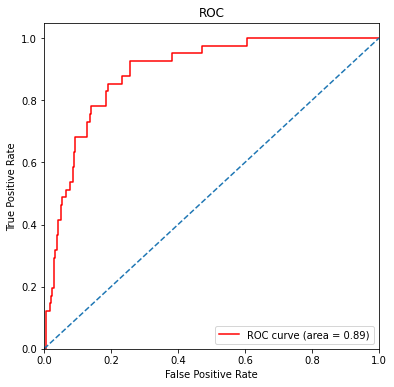

In [134]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# 2. 회귀

In [135]:
def rmse(true,pred):
    return np.sqrt(mean_squared_error(true,pred))

metrics = {'MSE': mean_squared_error,
              'RMSE': mean_absolute_error,
              'MAE': rmse,
              'R2': r2_score}

def linear_eval(model):
    for i in metrics.keys():
        print(f'{i} : {metrics[i](y_test_, model.predict(X_test_))}')

## 선형 모델

In [136]:
lr = LinearRegression()
lr.fit(X_train_, y_train_)
linear_eval(lr)

MSE : 0.37959710850229783
RMSE : 0.48139673183329795
MAE : 0.6161145254758225
R2 : 0.3468858137200871


In [137]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train_, y_train_)
linear_eval(ridge)

MSE : 0.37959704061469146
RMSE : 0.481396705872773
MAE : 0.6161144703824862
R2 : 0.34688593052381866


In [138]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_, y_train_)
linear_eval(lasso)

MSE : 0.37846754430759266
RMSE : 0.4812691170602232
MAE : 0.6151971588910279
R2 : 0.34882928057837415


## Support Vector Regressor(SVR)

In [139]:
svr = SVR(kernel='rbf',gamma='auto',C=1, epsilon=0.1)
svr.fit(X_train_, y_train_)
linear_eval(svr)

MSE : 0.3343751871308257
RMSE : 0.4293437239999129
MAE : 0.5782518371184182
R2 : 0.42469219769143507


# xgboost
xgboost를 이용하여 실험함

In [158]:
!pip install -q xgboost
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [184]:
# 깊이에 따른 변화
for a in depths:
  xgb = XGBClassifier(n_estimators=500,learning_rate=0.1,max_depth=a)
  xgb.fit(X_train,y_train)

  prediction = xgb.predict(X_test)
  xgbmatrix = confusion_matrix(y_test, prediction)
  print("depths = : {}".format(a))
  print(xgbmatrix)
  print("훈련 세트 정확도: {:.3f}".format(xgb.score(X_train,y_train)*100))
  print("테스트 세트 정확도: {:.3f}".format(xgb.score(X_test,y_test)*100))
  print('{:.4f}% 정밀도로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100))
  print('{:.4f}% 재현률로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100))

depths = : 3
[[261  18]
 [ 14  27]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 90.000
65.8537% 정밀도로 고객을 예측함
60.0000% 재현률로 고객을 예측함
depths = : 5
[[256  23]
 [ 12  29]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 89.062
70.7317% 정밀도로 고객을 예측함
55.7692% 재현률로 고객을 예측함
depths = : 7
[[258  21]
 [ 12  29]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 89.688
70.7317% 정밀도로 고객을 예측함
58.0000% 재현률로 고객을 예측함


In [ ]:

  xgb = XGBClassifier(

In [187]:
# learning_rate에 따른 변화
learning_rates =[1,0.5,0.1, 0.01,0.001] 
for a in learning_rates:
  xgb = XGBClassifier(n_estimators=500,learning_rate=a,max_depth=5)
  xgb.fit(X_train,y_train)

  prediction = xgb.predict(X_test)
  xgbmatrix = confusion_matrix(y_test, prediction)
  print("learning_rates = {}".format(a))
  print(xgbmatrix)
  print("훈련 세트 정확도: {:.3f}".format(xgb.score(X_train,y_train)*100))
  print("테스트 세트 정확도: {:.3f}".format(xgb.score(X_test,y_test)*100))
  print('{:.4f}% 정밀도로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100))
  print('{:.4f}% 재현률로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100))

learning_rates = 1
[[254  25]
 [ 14  27]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 87.812
65.8537% 정밀도로 고객을 예측함
51.9231% 재현률로 고객을 예측함
learning_rates = 0.7
[[259  20]
 [ 12  29]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 90.000
70.7317% 정밀도로 고객을 예측함
59.1837% 재현률로 고객을 예측함
learning_rates = 0.5
[[263  16]
 [ 10  31]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 91.875
75.6098% 정밀도로 고객을 예측함
65.9574% 재현률로 고객을 예측함
learning_rates = 0.1
[[256  23]
 [ 12  29]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 89.062
70.7317% 정밀도로 고객을 예측함
55.7692% 재현률로 고객을 예측함
learning_rates = 0.01
[[259  20]
 [ 20  21]]
훈련 세트 정확도: 97.420
테스트 세트 정확도: 87.500
51.2195% 정밀도로 고객을 예측함
51.2195% 재현률로 고객을 예측함
learning_rates = 0.001
[[258  21]
 [ 21  20]]
훈련 세트 정확도: 93.432
테스트 세트 정확도: 86.875
48.7805% 정밀도로 고객을 예측함
48.7805% 재현률로 고객을 예측함


In [176]:
# n_estimators 따른 변화
n_estimators =[5000, 1000,500, 100] 
for a in n_estimators:
  xgb = XGBClassifier(n_estimators=a,learning_rate=0.1,max_depth=5)
  xgb.fit(X_train,y_train)

  prediction = xgb.predict(X_test)
  xgbmatrix = confusion_matrix(y_test, prediction)
  print("n_estimators = {}".format(a))
  print(xgbmatrix)
  print("훈련 세트 정확도: {:.3f}".format(xgb.score(X_train,y_train)*100))
  print("테스트 세트 정확도: {:.3f}".format(xgb.score(X_test,y_test)*100))
  print('{:.4f}% 정밀도로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100))
  print('{:.4f}% 재현률로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100))

n_estimators = 5000
[[261  18]
 [  9  32]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 91.562
78.0488% 정밀도로 고객을 예측함
64.0000% 재현률로 고객을 예측함
n_estimators = 1000
[[256  23]
 [  9  32]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 90.000
78.0488% 정밀도로 고객을 예측함
58.1818% 재현률로 고객을 예측함
n_estimators = 500
[[256  23]
 [ 12  29]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 89.062
70.7317% 정밀도로 고객을 예측함
55.7692% 재현률로 고객을 예측함
n_estimators = 100
[[258  21]
 [ 16  25]]
훈련 세트 정확도: 99.375
테스트 세트 정확도: 88.438
60.9756% 정밀도로 고객을 예측함
54.3478% 재현률로 고객을 예측함


In [194]:

xgb = XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=7)
xgb.fit(X_train,y_train)

prediction = xgb.predict(X_test)
xgbmatrix = confusion_matrix(y_test, prediction)
print(xgbmatrix)
print("훈련 세트 정확도: {:.3f}".format(xgb.score(X_train,y_train)*100))
print("테스트 세트 정확도: {:.3f}".format(xgb.score(X_test,y_test)*100))
print('{:.4f}% 정밀도로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100))
print('{:.4f}% 재현률로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100))

[[258  21]
 [ 15  26]]
훈련 세트 정확도: 100.000
테스트 세트 정확도: 88.750
63.4146% 정밀도로 고객을 예측함
55.3191% 재현률로 고객을 예측함


어떤 결과든 낮은 정밀고 재현율을 보여준다.
이는 테스트 데이터의 숫자가 작음으로 예상된다.